## 1. Import Required Libraries

In [3]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Image processing
from PIL import Image
import cv2

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch Version: 2.8.0+cpu
CUDA Available: False


## 2. GPU Configuration

In [5]:
# Set device (CUDA GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🔥 Using device: {device}")

if device.type == 'cuda':
    print("✅ GPU acceleration enabled!")
    print(f"   Device: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ Running on CPU - Training will be slower")
    print("💡 Tip: Use Google Colab for free GPU access")


🔥 Using device: cpu
⚠️ Running on CPU - Training will be slower
💡 Tip: Use Google Colab for free GPU access


## 3. Dataset Exploration

In [6]:
# Set paths
DATA_DIR = Path('data')
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'

# Check dataset structure
print("Dataset Directory Structure:")
print(f"Train directory exists: {TRAIN_DIR.exists()}")
print(f"Test directory exists: {TEST_DIR.exists()}")

# Count number of classes
train_classes = [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(TRAIN_DIR / d) and d != 'letters']
num_classes = len(train_classes)
print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {sorted(train_classes, key=lambda x: int(x))[:10]}...") # Show first 10

Dataset Directory Structure:
Train directory exists: True
Test directory exists: True

Number of classes: 156
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']...


In [7]:
# Count images per class
class_counts = {}
for class_name in train_classes:
    class_path = TRAIN_DIR / class_name
    images = [f for f in os.listdir(class_path) if f.endswith(('.bmp', '.tiff', '.jpg', '.png'))]
    class_counts[class_name] = len(images)

print(f"\nTotal training images: {sum(class_counts.values())}")
print(f"Average images per class: {sum(class_counts.values()) / num_classes:.2f}")
print(f"Min images in a class: {min(class_counts.values())}")
print(f"Max images in a class: {max(class_counts.values())}")


Total training images: 50296
Average images per class: 322.41
Min images in a class: 320
Max images in a class: 451


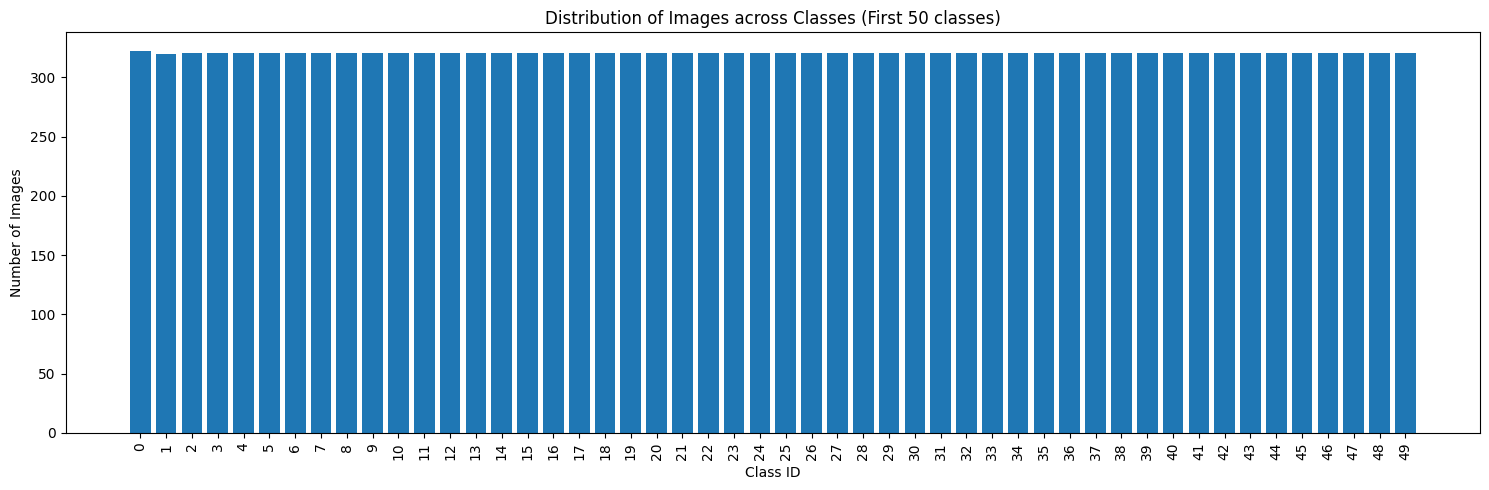

In [8]:
# Visualize class distribution
plt.figure(figsize=(15, 5))
sorted_classes = sorted(class_counts.items(), key=lambda x: int(x[0]))
classes, counts = zip(*sorted_classes[:50])  # Show first 50 classes

plt.bar(range(len(classes)), counts)
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.title('Distribution of Images across Classes (First 50 classes)')
plt.xticks(range(len(classes)), classes, rotation=90)
plt.tight_layout()
plt.show()

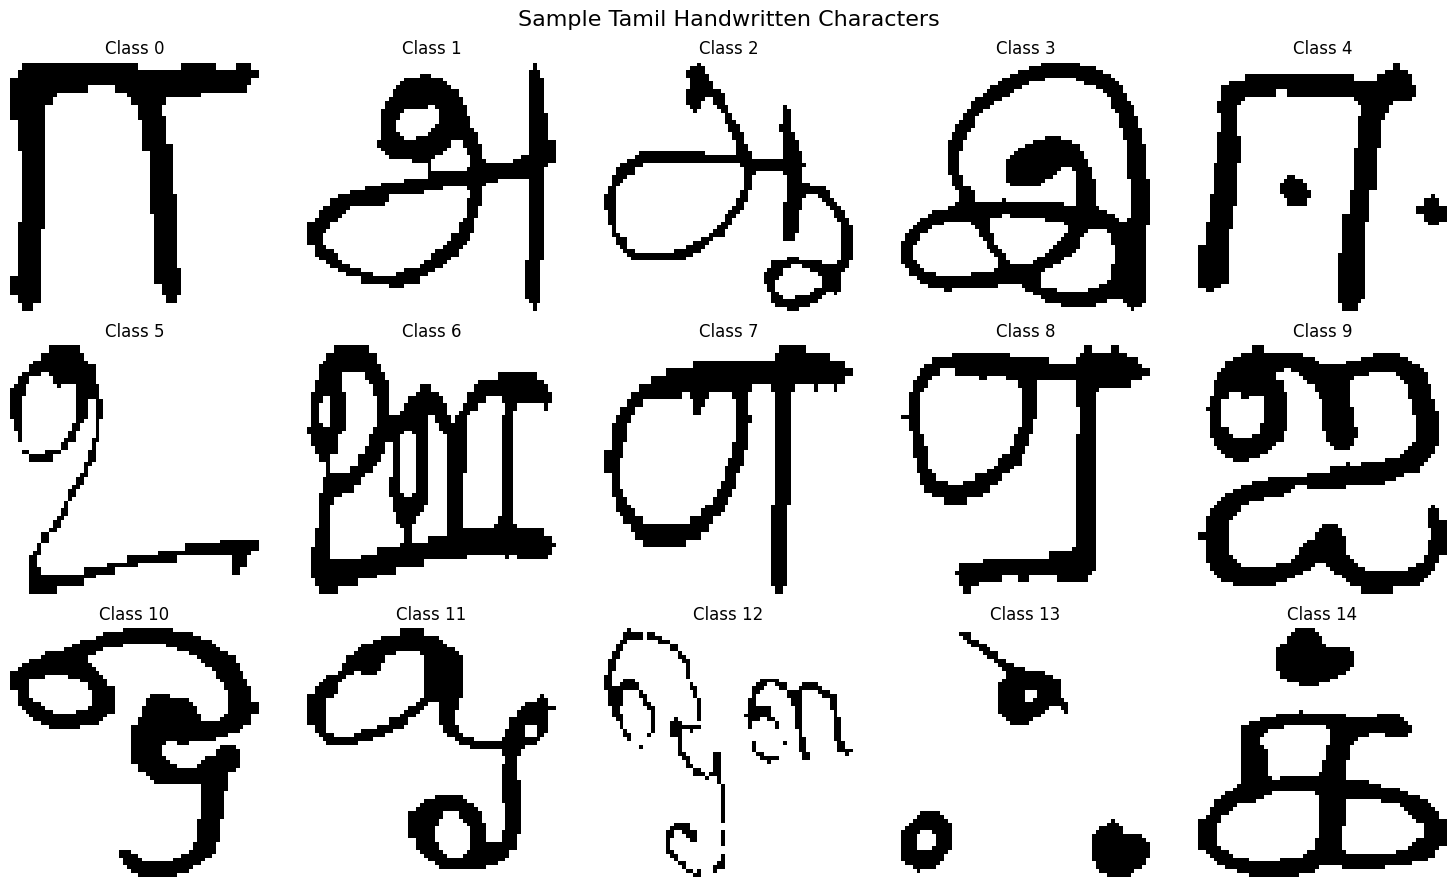

In [9]:
# Display sample images from different classes
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Sample Tamil Handwritten Characters', fontsize=16)

sample_classes = sorted(train_classes, key=lambda x: int(x))[:15]

for idx, class_name in enumerate(sample_classes):
    row = idx // 5
    col = idx % 5
    
    class_path = TRAIN_DIR / class_name
    images = [f for f in os.listdir(class_path) if f.endswith(('.bmp', '.tiff'))]
    
    if images:
        img_path = class_path / images[0]
        img = Image.open(img_path)
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(f'Class {class_name}')
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## 4. Configuration

In [10]:
# Configuration
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001
NUM_CLASSES = num_classes

# For quick testing, limit samples per class (set to None for full dataset)
MAX_SAMPLES_PER_CLASS = None  # None = use all data

print(f"Image dimensions: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Max samples per class: {MAX_SAMPLES_PER_CLASS}")

Image dimensions: 64x64
Batch size: 64
Epochs: 50
Learning rate: 0.001
Number of classes: 156
Max samples per class: None


## 5. PyTorch Dataset Class

In [11]:
class TamilCharacterDataset(Dataset):
    """
    PyTorch Dataset for Tamil handwritten characters
    """
    def __init__(self, data_dir, transform=None, max_samples_per_class=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Get sorted class names
        self.class_names = sorted(
            [d for d in os.listdir(data_dir) if os.path.isdir(data_dir / d) and d != 'letters'],
            key=lambda x: int(x)
        )
        
        # Load image paths and labels
        for class_id, class_name in enumerate(self.class_names):
            class_path = data_dir / class_name
            image_files = [f for f in os.listdir(class_path) 
                          if f.endswith(('.bmp', '.tiff', '.jpg', '.png'))]
            
            # Limit samples if specified
            if max_samples_per_class:
                image_files = image_files[:max_samples_per_class]
            
            for img_file in image_files:
                self.image_paths.append(class_path / img_file)
                self.labels.append(class_id)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        
        # Convert to PIL Image for transforms
        image = Image.fromarray(image)
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        
        return image, label

## 6. Data Augmentation & Loading

In [12]:
# Data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# No augmentation for validation
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

print("Transforms configured")

Transforms configured


In [13]:
# Create dataset
print("Loading dataset...")
full_dataset = TamilCharacterDataset(TRAIN_DIR, transform=None, max_samples_per_class=MAX_SAMPLES_PER_CLASS)

# Split into train and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_indices, val_indices = train_test_split(
    range(len(full_dataset)),
    test_size=0.2,
    random_state=42,
    stratify=full_dataset.labels
)

# Create separate datasets with different transforms
train_dataset = TamilCharacterDataset(TRAIN_DIR, transform=train_transform, max_samples_per_class=MAX_SAMPLES_PER_CLASS)
val_dataset = TamilCharacterDataset(TRAIN_DIR, transform=val_transform, max_samples_per_class=MAX_SAMPLES_PER_CLASS)

# Use SubsetRandomSampler for splitting
from torch.utils.data import Subset
train_dataset = Subset(train_dataset, train_indices)
val_dataset = Subset(val_dataset, val_indices)

print(f"\nTraining samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Loading dataset...

Training samples: 40236
Validation samples: 10060


In [14]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Set to 0 for Windows, 4 for Linux/Mac
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Train batches: 629
Validation batches: 158


## 7. Build CNN Model (PyTorch)

In [15]:
class TamilCNN(nn.Module):
    """
    CNN model for Tamil character recognition
    """
    def __init__(self, num_classes):
        super(TamilCNN, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        
        # Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)
        
        # Block 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn8 = nn.BatchNorm1d(256)
        self.dropout5 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = F.relu(self.bn8(self.fc2(x)))
        x = self.dropout5(x)
        x = self.fc3(x)
        
        return x

In [16]:
# Initialize model and move to GPU
model = TamilCNN(num_classes=NUM_CLASSES).to(device)

# Print model summary
from torchsummary import summary
try:
    summary(model, (1, IMG_HEIGHT, IMG_WIDTH))
except:
    print(model)
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
       BatchNorm2d-2           [-1, 32, 64, 64]              64
            Conv2d-3           [-1, 32, 64, 64]           9,248
       BatchNorm2d-4           [-1, 32, 64, 64]              64
         MaxPool2d-5           [-1, 32, 32, 32]               0
           Dropout-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          18,496
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]          36,928
      BatchNorm2d-10           [-1, 64, 32, 32]             128
        MaxPool2d-11           [-1, 64, 16, 16]               0
          Dropout-12           [-1, 64, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]          73,856
      BatchNorm2d-14          [-1, 128,

## 8. Training Setup

In [17]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("Training setup complete!")
print(f"Criterion: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Scheduler: ReduceLROnPlateau")

Training setup complete!
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: ReduceLROnPlateau


## 9. Training Loop

In [18]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

In [19]:
# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

In [20]:
# Training loop
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

print("\n🚀 Starting training...\n")

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch summary
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_pytorch.pth')
        print(f"✅ Best model saved! (Val Acc: {best_val_acc:.2f}%)")

print("\n✅ Training complete!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")


🚀 Starting training...


Epoch 1/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [01:46<00:00,  1.48it/s, loss=1.19, acc=83.7] 



Train Loss: 2.2909 | Train Acc: 45.56%
Val Loss: 0.6044 | Val Acc: 83.67%
✅ Best model saved! (Val Acc: 83.67%)

Epoch 2/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.47it/s, loss=1.33, acc=93]   



Train Loss: 0.8326 | Train Acc: 76.50%
Val Loss: 0.2420 | Val Acc: 93.04%
✅ Best model saved! (Val Acc: 93.04%)

Epoch 3/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.52it/s, loss=1.19, acc=95]    



Train Loss: 0.5752 | Train Acc: 83.23%
Val Loss: 0.1719 | Val Acc: 95.03%
✅ Best model saved! (Val Acc: 95.03%)

Epoch 4/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.51it/s, loss=1.49, acc=95.2]  



Train Loss: 0.4733 | Train Acc: 86.18%
Val Loss: 0.1646 | Val Acc: 95.19%
✅ Best model saved! (Val Acc: 95.19%)

Epoch 5/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.49it/s, loss=1.47, acc=95.9]  



Train Loss: 0.4092 | Train Acc: 87.84%
Val Loss: 0.1430 | Val Acc: 95.91%
✅ Best model saved! (Val Acc: 95.91%)

Epoch 6/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.52it/s, loss=1.53, acc=95.6]  



Train Loss: 0.3687 | Train Acc: 88.96%
Val Loss: 0.1423 | Val Acc: 95.60%

Epoch 7/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.55it/s, loss=1.39, acc=96.3]  



Train Loss: 0.3335 | Train Acc: 89.94%
Val Loss: 0.1278 | Val Acc: 96.30%
✅ Best model saved! (Val Acc: 96.30%)

Epoch 8/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:23<00:00,  6.64it/s, loss=1.45, acc=96.5]  



Train Loss: 0.3022 | Train Acc: 90.87%
Val Loss: 0.1195 | Val Acc: 96.50%
✅ Best model saved! (Val Acc: 96.50%)

Epoch 9/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.52it/s, loss=1.64, acc=96.9]  



Train Loss: 0.2843 | Train Acc: 91.34%
Val Loss: 0.1065 | Val Acc: 96.90%
✅ Best model saved! (Val Acc: 96.90%)

Epoch 10/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.58it/s, loss=1.84, acc=97]     



Train Loss: 0.2707 | Train Acc: 91.82%
Val Loss: 0.1009 | Val Acc: 97.05%
✅ Best model saved! (Val Acc: 97.05%)

Epoch 11/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:23<00:00,  6.61it/s, loss=1.69, acc=97.1]   



Train Loss: 0.2576 | Train Acc: 92.16%
Val Loss: 0.1025 | Val Acc: 97.13%
✅ Best model saved! (Val Acc: 97.13%)

Epoch 12/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.49it/s, loss=1.88, acc=97.1]  



Train Loss: 0.2507 | Train Acc: 92.34%
Val Loss: 0.1014 | Val Acc: 97.14%
✅ Best model saved! (Val Acc: 97.14%)

Epoch 13/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:26<00:00,  6.07it/s, loss=1.7, acc=97.3]    



Train Loss: 0.2406 | Train Acc: 92.59%
Val Loss: 0.0978 | Val Acc: 97.27%
✅ Best model saved! (Val Acc: 97.27%)

Epoch 14/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.24it/s, loss=1.84, acc=97]    



Train Loss: 0.2304 | Train Acc: 92.96%
Val Loss: 0.0986 | Val Acc: 97.00%

Epoch 15/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.24it/s, loss=1.73, acc=97.4]  



Train Loss: 0.2164 | Train Acc: 93.43%
Val Loss: 0.0940 | Val Acc: 97.36%
✅ Best model saved! (Val Acc: 97.36%)

Epoch 16/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.18it/s, loss=1.97, acc=97.2]   



Train Loss: 0.2088 | Train Acc: 93.51%
Val Loss: 0.0924 | Val Acc: 97.24%

Epoch 17/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.11it/s, loss=2.29, acc=97.6]  



Train Loss: 0.2010 | Train Acc: 93.83%
Val Loss: 0.0885 | Val Acc: 97.55%
✅ Best model saved! (Val Acc: 97.55%)

Epoch 18/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.20it/s, loss=2.22, acc=97.3]   



Train Loss: 0.1993 | Train Acc: 93.78%
Val Loss: 0.0930 | Val Acc: 97.35%

Epoch 19/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.19it/s, loss=2.13, acc=97.2]   



Train Loss: 0.1991 | Train Acc: 93.76%
Val Loss: 0.0958 | Val Acc: 97.24%

Epoch 20/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.25it/s, loss=2.3, acc=97.3]    



Train Loss: 0.1867 | Train Acc: 94.25%
Val Loss: 0.0880 | Val Acc: 97.30%

Epoch 21/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:26<00:00,  6.07it/s, loss=2.36, acc=97.6]   



Train Loss: 0.1799 | Train Acc: 94.39%
Val Loss: 0.0881 | Val Acc: 97.59%
✅ Best model saved! (Val Acc: 97.59%)

Epoch 22/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.21it/s, loss=2.24, acc=97.7]   



Train Loss: 0.1828 | Train Acc: 94.37%
Val Loss: 0.0891 | Val Acc: 97.70%
✅ Best model saved! (Val Acc: 97.70%)

Epoch 23/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.19it/s, loss=2.11, acc=97.5]   



Train Loss: 0.1689 | Train Acc: 94.70%
Val Loss: 0.0914 | Val Acc: 97.50%

Epoch 24/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.19it/s, loss=2.33, acc=97.6]   



Train Loss: 0.1643 | Train Acc: 94.81%
Val Loss: 0.0865 | Val Acc: 97.58%

Epoch 25/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.19it/s, loss=2.44, acc=97.7]   



Train Loss: 0.1629 | Train Acc: 94.90%
Val Loss: 0.0887 | Val Acc: 97.72%
✅ Best model saved! (Val Acc: 97.72%)

Epoch 26/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.19it/s, loss=2.15, acc=97.7]   



Train Loss: 0.1632 | Train Acc: 94.97%
Val Loss: 0.0864 | Val Acc: 97.68%

Epoch 27/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.32it/s, loss=2.46, acc=97.7]   



Train Loss: 0.1483 | Train Acc: 95.34%
Val Loss: 0.0882 | Val Acc: 97.69%

Epoch 28/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.39it/s, loss=2.62, acc=97.6]   



Train Loss: 0.1501 | Train Acc: 95.24%
Val Loss: 0.0899 | Val Acc: 97.63%

Epoch 29/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.38it/s, loss=2.22, acc=97.7]   



Train Loss: 0.1457 | Train Acc: 95.39%
Val Loss: 0.0865 | Val Acc: 97.74%
✅ Best model saved! (Val Acc: 97.74%)

Epoch 30/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.28it/s, loss=2.5, acc=97.6]    



Train Loss: 0.1462 | Train Acc: 95.38%
Val Loss: 0.0885 | Val Acc: 97.61%

Epoch 31/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.33it/s, loss=2.5, acc=97.8]    



Train Loss: 0.1419 | Train Acc: 95.55%
Val Loss: 0.0842 | Val Acc: 97.78%
✅ Best model saved! (Val Acc: 97.78%)

Epoch 32/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.19it/s, loss=2.71, acc=97.6]   



Train Loss: 0.1431 | Train Acc: 95.54%
Val Loss: 0.0874 | Val Acc: 97.62%

Epoch 33/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.12it/s, loss=2.72, acc=97.8]    



Train Loss: 0.1398 | Train Acc: 95.70%
Val Loss: 0.0808 | Val Acc: 97.82%
✅ Best model saved! (Val Acc: 97.82%)

Epoch 34/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:26<00:00,  6.00it/s, loss=2.78, acc=97.8]   



Train Loss: 0.1290 | Train Acc: 95.99%
Val Loss: 0.0842 | Val Acc: 97.83%
✅ Best model saved! (Val Acc: 97.83%)

Epoch 35/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.35it/s, loss=3.07, acc=97.9]   



Train Loss: 0.1360 | Train Acc: 95.71%
Val Loss: 0.0882 | Val Acc: 97.88%
✅ Best model saved! (Val Acc: 97.88%)

Epoch 36/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.41it/s, loss=2.84, acc=97.8]    



Train Loss: 0.1341 | Train Acc: 95.82%
Val Loss: 0.0837 | Val Acc: 97.79%

Epoch 37/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.25it/s, loss=2.71, acc=97.9]    



Train Loss: 0.1239 | Train Acc: 95.95%
Val Loss: 0.0841 | Val Acc: 97.85%

Epoch 38/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.17it/s, loss=2.53, acc=97.8]   



Train Loss: 0.1248 | Train Acc: 95.99%
Val Loss: 0.0860 | Val Acc: 97.79%

Epoch 39/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:26<00:00,  6.05it/s, loss=2.91, acc=97.8]    



Train Loss: 0.1271 | Train Acc: 95.94%
Val Loss: 0.0859 | Val Acc: 97.76%

Epoch 40/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.20it/s, loss=2.84, acc=97.9]    



Train Loss: 0.1072 | Train Acc: 96.54%
Val Loss: 0.0817 | Val Acc: 97.92%
✅ Best model saved! (Val Acc: 97.92%)

Epoch 41/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.41it/s, loss=2.81, acc=97.9]    



Train Loss: 0.0977 | Train Acc: 96.90%
Val Loss: 0.0810 | Val Acc: 97.90%

Epoch 42/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.26it/s, loss=2.62, acc=97.9]    



Train Loss: 0.0969 | Train Acc: 97.02%
Val Loss: 0.0845 | Val Acc: 97.85%

Epoch 43/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.34it/s, loss=2.82, acc=98.1]    



Train Loss: 0.0932 | Train Acc: 96.89%
Val Loss: 0.0809 | Val Acc: 98.06%
✅ Best model saved! (Val Acc: 98.06%)

Epoch 44/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.23it/s, loss=2.83, acc=98]      



Train Loss: 0.0917 | Train Acc: 97.06%
Val Loss: 0.0809 | Val Acc: 98.00%

Epoch 45/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.29it/s, loss=3.01, acc=97.9]   



Train Loss: 0.0927 | Train Acc: 97.06%
Val Loss: 0.0854 | Val Acc: 97.94%

Epoch 46/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.35it/s, loss=3.03, acc=98.1]    



Train Loss: 0.0829 | Train Acc: 97.25%
Val Loss: 0.0815 | Val Acc: 98.07%
✅ Best model saved! (Val Acc: 98.07%)

Epoch 47/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.20it/s, loss=2.85, acc=98]      



Train Loss: 0.0811 | Train Acc: 97.40%
Val Loss: 0.0805 | Val Acc: 98.04%

Epoch 48/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:25<00:00,  6.18it/s, loss=2.82, acc=98.1]    



Train Loss: 0.0789 | Train Acc: 97.48%
Val Loss: 0.0783 | Val Acc: 98.10%
✅ Best model saved! (Val Acc: 98.10%)

Epoch 49/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.55it/s, loss=2.95, acc=98.2]    



Train Loss: 0.0735 | Train Acc: 97.58%
Val Loss: 0.0768 | Val Acc: 98.17%
✅ Best model saved! (Val Acc: 98.17%)

Epoch 50/50
--------------------------------------------------


Validation: 100%|██████████| 158/158 [00:24<00:00,  6.51it/s, loss=3.19, acc=98.1]    


Train Loss: 0.0760 | Train Acc: 97.57%
Val Loss: 0.0761 | Val Acc: 98.13%

✅ Training complete!
Best Validation Accuracy: 98.17%


## 10. Training Visualization

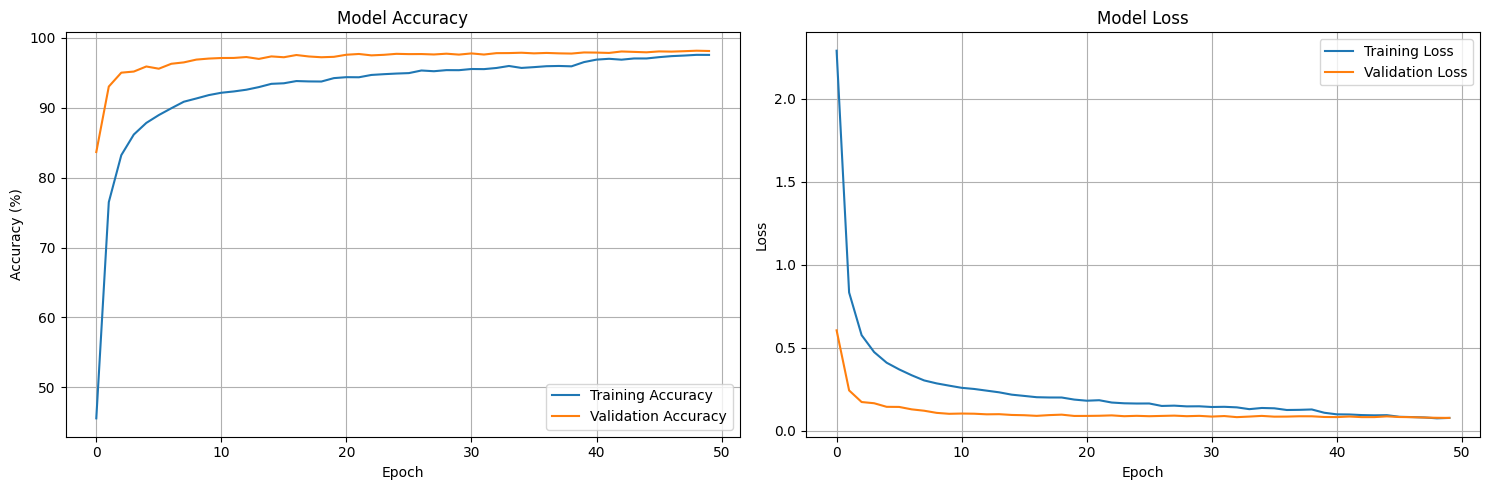


Best Validation Accuracy: 98.17%
At Epoch: 49


In [21]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history['train_acc'], label='Training Accuracy')
axes[0].plot(history['val_acc'], label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history['train_loss'], label='Training Loss')
axes[1].plot(history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print best results
best_epoch = np.argmax(history['val_acc'])
print(f"\nBest Validation Accuracy: {history['val_acc'][best_epoch]:.2f}%")
print(f"At Epoch: {best_epoch + 1}")

## 11. Model Evaluation

In [22]:
# Load best model
model.load_state_dict(torch.load('best_model_pytorch.pth'))
model.eval()

# Get predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Evaluating'):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nFinal Validation Accuracy: {accuracy * 100:.2f}%")

Evaluating: 100%|██████████| 158/158 [00:24<00:00,  6.49it/s]



Final Validation Accuracy: 98.17%


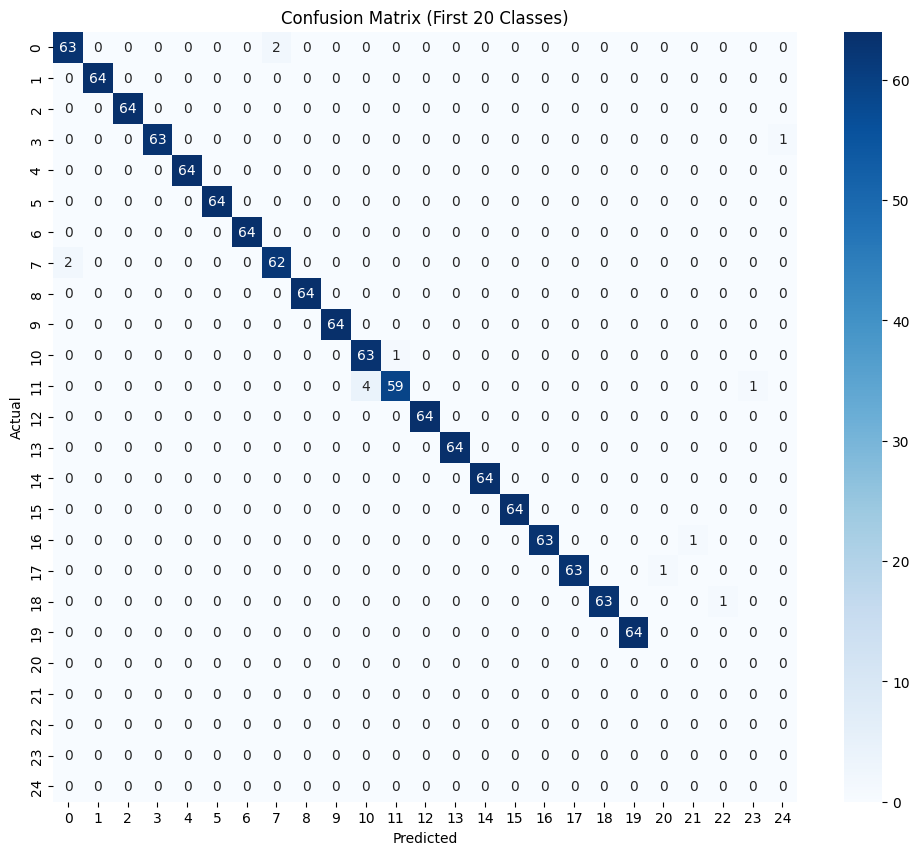

In [23]:
# Confusion matrix for first 20 classes
sample_indices = np.where(all_labels < 20)[0]
cm = confusion_matrix(all_labels[sample_indices], all_preds[sample_indices])

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (First 20 Classes)')
plt.show()

## 12. Save Model

In [24]:
# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'num_classes': NUM_CLASSES,
    'accuracy': best_val_acc
}, 'tamil_ocr_pytorch_final.pth')

print("Model saved as 'tamil_ocr_pytorch_final.pth'")

# Save class names
import json
class_names = full_dataset.class_names
with open('class_names_pytorch.json', 'w', encoding='utf-8') as f:
    json.dump(class_names, f, ensure_ascii=False, indent=2)
print("Class names saved as 'class_names_pytorch.json'")

Model saved as 'tamil_ocr_pytorch_final.pth'
Class names saved as 'class_names_pytorch.json'


## 13. Inference Function

In [26]:
def predict_character(img_path, model, class_names, device):
    """
    Predict Tamil character from image path
    """
    model.eval()
    
    # Load and preprocess image
    image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    
    # Transform
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    predicted_class = predicted.item()
    confidence = confidence.item()
    
    # Display result
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(f'Predicted Class: {class_names[predicted_class]}\nConfidence: {confidence:.2%}')
    plt.axis('off')
    plt.show()
    
    return predicted_class, confidence

print("Inference function ready!")

Inference function ready!


Testing with image from class: 60
Image path: data\train\60\41889.bmp



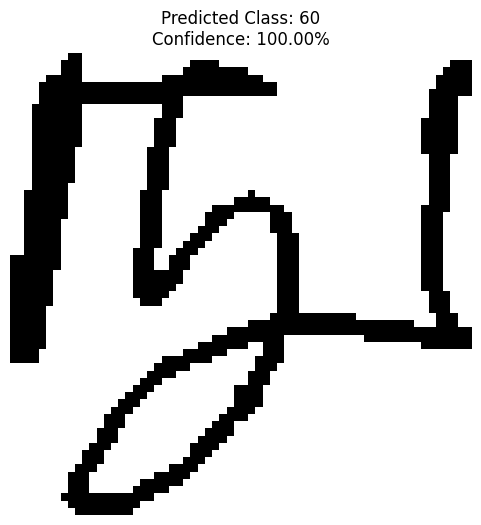


✅ Actual Class: 60
🔮 Predicted Class: 60
📊 Confidence: 100.00%
✅ CORRECT PREDICTION!


In [28]:
# Test the model with a random sample from validation set
import random

# Get a random validation image
random_idx = random.randint(0, len(val_dataset) - 1)
actual_idx = val_indices[random_idx]

# Get the actual image path
test_img_path = full_dataset.image_paths[actual_idx]
true_label = full_dataset.labels[actual_idx]
true_class_name = class_names[true_label]

print(f"Testing with image from class: {true_class_name}")
print(f"Image path: {test_img_path}")
print("\n" + "="*60)

# Use the inference function
predicted_class, confidence = predict_character(test_img_path, model, class_names, device)

print(f"\n{'='*60}")
print(f"✅ Actual Class: {true_class_name}")
print(f"🔮 Predicted Class: {class_names[predicted_class]}")
print(f"📊 Confidence: {confidence:.2%}")
print(f"{'='*60}")

if predicted_class == true_label:
    print("✅ CORRECT PREDICTION!")
else:
    print("❌ INCORRECT PREDICTION")


## 14. Manual Image Testing
Upload and test your own Tamil character images

Testing manual image: test.jpeg


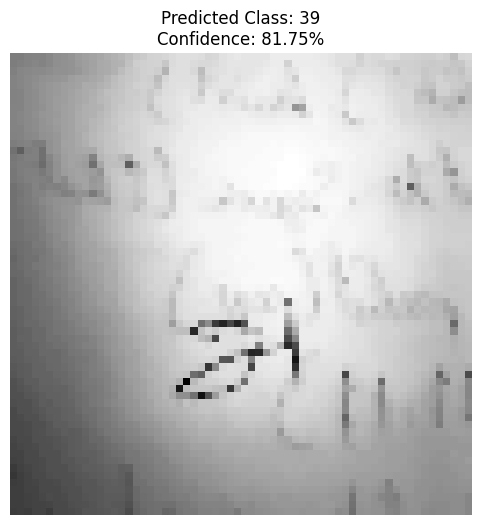


🔮 Predicted Class: 39
📊 Confidence: 81.75%


In [36]:
# Test with your own image
# Replace the path below with your image file path

# Example: 
# manual_img_path = r"C:\Users\gokulp\Desktop\my_tamil_character.bmp"
# Or use a path from your dataset:
# manual_img_path = r"data\train\50\12345.bmp"

manual_img_path = r"test.jpeg"  # Replace this with your image path

print(f"Testing manual image: {manual_img_path}")
print("="*60)

# Check if file exists
if os.path.exists(manual_img_path):
    predicted_class, confidence = predict_character(manual_img_path, model, class_names, device)
    
    print(f"\n{'='*60}")
    print(f"🔮 Predicted Class: {class_names[predicted_class]}")
    print(f"📊 Confidence: {confidence:.2%}")
    print(f"{'='*60}")
else:
    print(f"❌ Error: File not found at {manual_img_path}")
    print("\n💡 Instructions:")
    print("1. Change the 'manual_img_path' variable above to your image path")
    print("2. Make sure to use r\"\" for Windows paths or forward slashes /")
    print("3. Supported formats: .bmp, .tiff, .jpg, .png")
    print("\nExample paths:")
    print('   manual_img_path = r"C:\\Users\\gokulp\\Desktop\\my_image.bmp"')
    print('   manual_img_path = "data/train/25/image.bmp"')